# Table of Contents
1. Business Understanding
2. Data Understanding
3. Data Cleaning
4. Data Preprocessing
5. Exploratory Data Analysis
6. Data Transformation
7. Modeling
8. Final Model
9. Model Explanation
10. Conclusion
11. Recommendation
12. Deployment

# 1. Business Understanding

### 1.1. Context

Service-based companies generate revenue through intangible services, making active customer involvement essential. Retaining customers and preventing churn—when customers switch to competitors or discontinue their subscriptions—is a major challenge for these providers. High churn rates can significantly impact a company's revenue and profitability because acquiring new customers is generally more expensive than retaining existing ones. Telecommunication (Telco) companies, in particular, face the challenge of managing customer churn.

To reduce customer churn, a telco company providing home phone and internet services, usually implement general retention offer to their customer based on basic statistical analysis. This predictive analytics aims to identify customers who might discontinue using their services (Churn), utilizing machine learning algorithm to develop an appropriate prediction model that can determine whether a customer will churn or not.

### 1.2. Target

1 : Churn <br>
0 : No Churn

### 1.3. Problem Statement

Acquiring new customers is significantly more expensive than retaining existing ones. It can cost up to five times more to acquire a new customer than to retain an existing one​​. The Customer Acquisition Cost (CAC) in the telecom industry varies but is typically around $315 per customer​​. This figure represents the average cost a telecom company incurs to acquire a new customer, including marketing and sales expenses (Source: [Article 1](https://startuptalky.com/cac-by-industry/) & [Article 2](https://www.revechat.com/blog/customer-acquisition-cost/)).<br>

Retaining existing customers is generally less costly. It involves maintaining satisfaction and loyalty through customer service, personalized marketing, and ongoing engagement. A strong retention strategy can lead to a higher return on investment. For example, a 5% increase in customer retention can boost profits by 25% to 95%​ (Source: [Article 3](https://www.paddle.com/resources/customer-acquisition-vs-retention) & [Article 4](https://www.wellnessliving.com/blog/customer-retention-vs-customer-acquisition-which-better/))​.

In conclusion, losing customers forces the company to acquire new ones, which is more expensive than retaining existing customers through specific strategies. Thus, customer churn can be very costly for the company.

To provide clear objectives, let's frame the problem as described by stakeholder in a user story. The user story is as follows:

`As a Retention Campaign Manager` <br>
`I would like to know the users who are likely to churn` <br>
`So that we can give them retention strategy` <br>

### 1.4. Goal

Predict which customer that probably will churn. Thus, we can minimize potential revenue loss and Customer Acquisition Cost (CAC).

### 1.5. ML Objective

Create a predictive model to identify customers at risk of churning. By training on historical data, the model will recognize patterns linked to churn and use this insight to predict future churn events. The goal is to achieve a high F2 Score in predictions with low False Negative (FN), ensuring the company and stakeholders can depend on the model for informed decision-making.

### 1.6. Metric Evaluation

We will use F2 Score because we interested in False Negative and False Positive, but weighted in False Negative since it more costly.

- Type I Error/ False Positive (FP): If the Customer is predicted to churn, but they actually stay.
- Type II Error/ False Negative (FN): If the Customer is predicted to stay, but they actually churn.

##### 1.6.1 False Positive (FP) Cost 

This can lead to companies providing unnecessary retention offer to customers who are not planning to quit, thus increasing operating costs or Customer Retention Cost (CRC).

##### 1.6.1 False Negative (FN) Cost

- Potential revenue loss: A customer predicted to stay but who actually churns represents lost future revenue from their continued subscription.
- Increased customer acquisition cost: To replace the churned customer, the company needs to acquire a new one, incurring the Customer Acquisition Cost (CAC) mentioned earlier (around $315). <br><br>

We will prioritize **reducing False Negatives (FNs)** since they are more costly than False Positives (FPs). Offering retention deals to customers who don't intend to leave might seem wasteful, but it can actually boost satisfaction and loyalty. Therefore, we'll use the **F2 Score**, aiming to minimize potential losses while still lowering the operational costs of retention offers. <br>

In [1]:
# Import necessary library

import numpy as np 
import pandas as pd 

import seaborn as sns 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from pySankey.sankey import sankey
from scipy.stats.contingency import association
from statsmodels.stats import proportion 
from scipy.stats import chi2_contingency
import plotly.io as pio
pio.renderers.default = "jupyterlab+png"

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from category_encoders import BinaryEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, InstanceHardnessThreshold
from imblearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer, fbeta_score

import shap
import lime
from lime import lime_tabular
import pickle

# 2. Data Understanding
### 2.1. Context
The dataset represents customer profiles who have left the telco company. A churn in telco and other subscription-based services means a situation when the customer leaves the service provider. 
### 2.2. Features
- Dependents: Whether the customer lives with any dependents. Dependents could be children, parents, grandparents, etc.
- Tenure: Number of months the customer has stayed with the company.
- OnlineSecurity: Whether the customer has online security or not.
- OnlineBackup: Whether the customer has online backup or not.
- InternetService: Whether the client is subscribed to Internet service.
- DeviceProtection: Whether the client has device protection or not.
- TechSupport: Whether the client has tech support or not 
- Contract: Type of contract according to duration.
- PaperlessBilling: Bills issued in paperless form.
- MonthlyCharges: Indicates the customer’s current total monthly charge for all their services from the company.
- Churn: Whether the customer churns or not.


In [2]:
df = pd.read_csv('data_telco_customer_churn.csv')
df

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes


In [3]:
# Check data type, nullity, and unique values

pd.set_option('display.max_colwidth',None)

pd.DataFrame({
    'features':df.columns.values,
    'data_type':df.dtypes.values,
    'null':df.isna().mean().values *100,
    'any_negative':[True if df[i].dtype == int and (df[i] < 0).any() else False for i in df.columns],
    'n_unique':df.nunique().values,
    'sample_unique':[df[i].unique() for i in df.columns]
})

,features,data_type,null,any_negative,n_unique,sample_unique
0,Dependents,object,0.0,False,2,"[Yes, No]"
1,tenure,int64,0.0,False,73,"[9, 14, 64, 72, 3, 40, 17, 11, 8, 47, 18, 5, 1, 48, 13, 58, 7, 4, 70, 34, 31, 37, 15, 71, 10, 43, 22, 33, 69, 54, 63, 55, 66, 56, 32, 26, 24, 2, 51, 23, 49, 28, 36, 45, 42, 6, 61, 59, 67, 65, 0, 16, 52, 41, 25, 62, 20, 50, 30, 60, 19, 35, 57, 27, 44, 53, 12, 46, 39, 29, 38, 68, 21]"
2,OnlineSecurity,object,0.0,False,3,"[No, Yes, No internet service]"
3,OnlineBackup,object,0.0,False,3,"[No, Yes, No internet service]"
4,InternetService,object,0.0,False,3,"[DSL, Fiber optic, No]"
5,DeviceProtection,object,0.0,False,3,"[Yes, No internet service, No]"
6,TechSupport,object,0.0,False,3,"[Yes, No, No internet service]"
7,Contract,object,0.0,False,3,"[Month-to-month, Two year, One year]"
8,PaperlessBilling,object,0.0,False,2,"[Yes, No]"
9,MonthlyCharges,float64,0.0,False,1422,"[72.9, 82.65, 47.85, 69.65, 23.6, 74.55, 19.7, 44.05, 73.5, 40.3, 33.6, 96.25, 70.45, 30.55, 44.8, 20.0, 81.5, 94.35, 35.3, 50.7, 106.05, 56.3, 20.65, 98.9, 40.2, 81.2, 19.45, 116.1, 55.2, 94.45, 84.85, 19.6, 79.0, 74.7, 30.4, 55.8, 104.5, 70.55, 55.25, 96.65, 88.85, 109.25, 104.75, 74.4, 79.4, 74.1, 73.05, 94.6, 70.35, 79.6, 79.5, 90.7, 81.0, 87.75, 118.65, 24.8, 105.25, 57.8, 19.0, 25.7, 54.2, 44.85, 19.95, 81.05, 20.35, 85.25, 67.45, 100.3, 20.95, 105.2, 26.35, 82.15, 102.6, 106.15, 23.95, 115.8, 66.85, 90.35, 89.85, 73.35, 104.45, 35.45, 88.4, 70.5, 25.1, 39.0, 83.25, 74.3, 54.3, 50.45, 86.0, 19.55, 103.5, 91.7, 64.85, 99.65, 68.75, 106.25, 75.9, 94.4, ...]"


# 3. Data Cleaning

### 3.1. Check Missing Values

In [4]:
df.isna().sum()

Dependents          0
tenure              0
OnlineSecurity      0
OnlineBackup        0
InternetService     0
DeviceProtection    0
TechSupport         0
Contract            0
PaperlessBilling    0
MonthlyCharges      0
Churn               0
dtype: int64

### 3.2. Check Duplicate Values

In [5]:
print(f'duplicate data: {df.duplicated().sum()}')
print(f'duplicate data percentage : {df.duplicated().sum()/len(df)*100:.2f}%')

duplicate data: 77
duplicate data percentage : 1.56%


In [6]:
df[df.duplicated()]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
624,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
701,No,41,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.65,No
786,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.65,Yes
951,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.15,Yes
1266,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
...,...,...,...,...,...,...,...,...,...,...,...
4759,No,4,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.05,No
4786,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,20.35,No
4788,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,70.10,Yes
4866,No,1,No,No,DSL,No,No,Month-to-month,Yes,55.00,Yes


In [7]:
# Index it's original one and the duplicates

df[(df['Dependents'] == 'No') & (df['tenure'] == 1) & (df['OnlineSecurity'] == 'No internet service') & (df['OnlineBackup'] == 'No internet service') & (df['InternetService'] == 'No') & (df['DeviceProtection'] == 'No internet service') & (df['TechSupport'] == 'No internet service') & (df['Contract'] == 'Month-to-month') & (df['PaperlessBilling'] == 'No') & (df['MonthlyCharges'] == 19.65) & (df['Churn'] == 'No')]

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
187,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
624,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
1266,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No
3801,No,1,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,No,19.65,No


In [8]:
df.drop_duplicates()

,Dependents,tenure,OnlineSecurity,OnlineBackup,InternetService,DeviceProtection,TechSupport,Contract,PaperlessBilling,MonthlyCharges,Churn
0,Yes,9,No,No,DSL,Yes,Yes,Month-to-month,Yes,72.90,Yes
1,No,14,No,Yes,Fiber optic,Yes,No,Month-to-month,Yes,82.65,No
2,No,64,Yes,No,DSL,Yes,Yes,Two year,No,47.85,Yes
3,No,72,Yes,Yes,DSL,Yes,Yes,Two year,No,69.65,No
4,No,3,No internet service,No internet service,No,No internet service,No internet service,Month-to-month,Yes,23.60,No
...,...,...,...,...,...,...,...,...,...,...,...
4925,No,15,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,103.45,No
4926,Yes,10,No,No,Fiber optic,Yes,Yes,Month-to-month,Yes,91.10,No
4927,No,58,No internet service,No internet service,No,No internet service,No internet service,Two year,No,20.75,No
4928,No,1,No,No,Fiber optic,No,No,Month-to-month,Yes,69.75,Yes


# 4. Data Preprocessing

In [9]:
# Transform Churn into 1 and not-Churn into 0
df['Churn'] = np.where(df['Churn'] == 'Yes',1,0)

In [10]:
# Add total charges paid by the customer until now
df['TotalCharged'] = df['MonthlyCharges'] * df['tenure']

# 5. Exploratory Data Analysis

### 5.1. Check Outliers

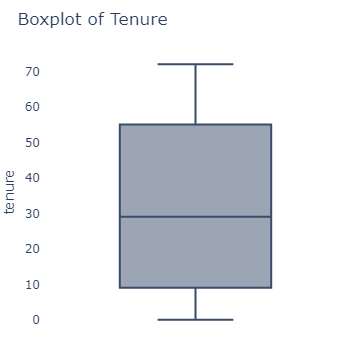

In [11]:
# Create boxplot for tenure
fig_box = px.box(df, y='tenure', title='Boxplot of Tenure', color_discrete_sequence=['#3A4C6A'])

fig_box.update_layout(
    autosize=False,
    width=350,
    height=350,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

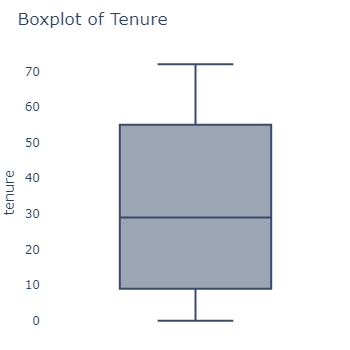

Tenure have no outliers. With maximum value of 72 and 0 as the minimum Tenure.

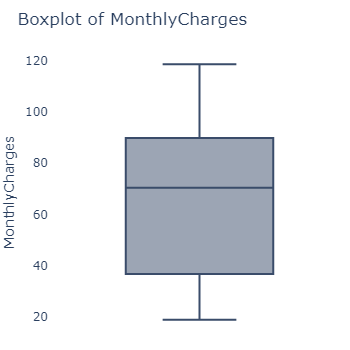

In [12]:
# Create boxplot for MonthlyCharges
fig_box = px.box(df, y='MonthlyCharges', title='Boxplot of MonthlyCharges', color_discrete_sequence=['#3A4C6A'])

fig_box.update_layout(
    autosize=False,
    width=350,
    height=350,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

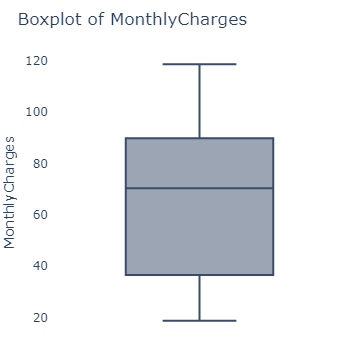

MonthlyCharges have no outliers. With maximum value of 118.65 and 18.8 as the minimum MonthlyCharges.

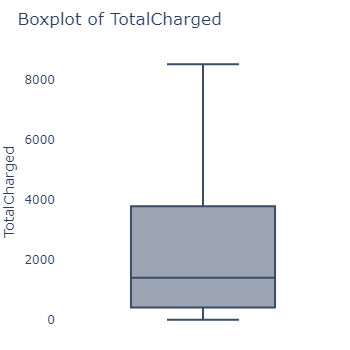

In [13]:
# Create boxplot for TotalCharged
fig_box = px.box(df, y='TotalCharged', title='Boxplot of TotalCharged', color_discrete_sequence=['#3A4C6A'])

fig_box.update_layout(
    autosize=False,
    width=350,
    height=350,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

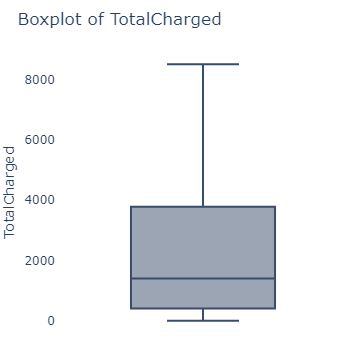

TotalCharged have no outliers. With maximum value of 8510 and 0 as the minimum MonthlyCharges. We can see that the distribution is not normal, we will do scaling later on.

### 5.2. Check Distribution

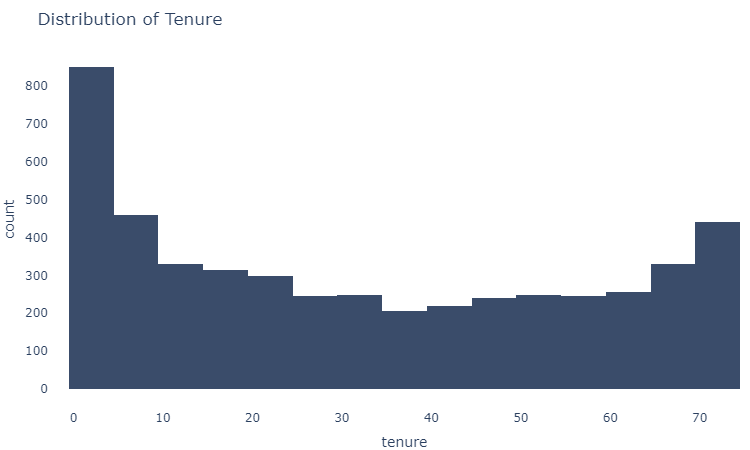

In [14]:
# Create distribution plot for tenure with line plot
fig_dist = px.histogram(df, x='tenure', nbins=30, title='Distribution of Tenure', color_discrete_sequence=['#3A4C6A'], histfunc='count')

fig_dist.update_layout(
    autosize=False,
    width=750,
    height=450,
    margin=dict(
        l=0,
        r=10,
        b=0,
        t=50,
        pad=20
    ),
    plot_bgcolor='white',
    showlegend=False
)

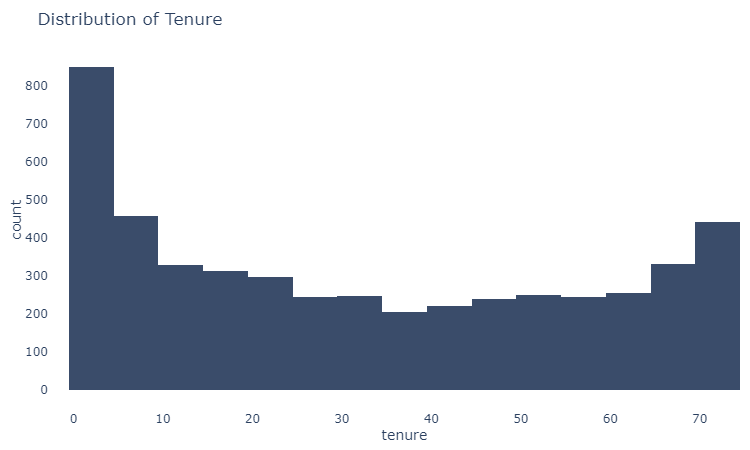

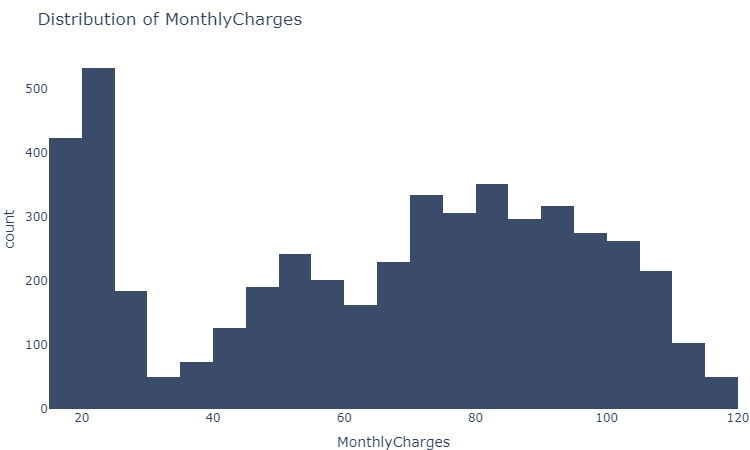

In [15]:
# Create distribution plot for MonthlyCharges with line plot
fig_dist = px.histogram(df, x='MonthlyCharges', nbins=30, title='Distribution of MonthlyCharges', color_discrete_sequence=['#3A4C6A'], histfunc='count')

fig_dist.update_layout(
    autosize=False,
    width=750,
    height=450,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

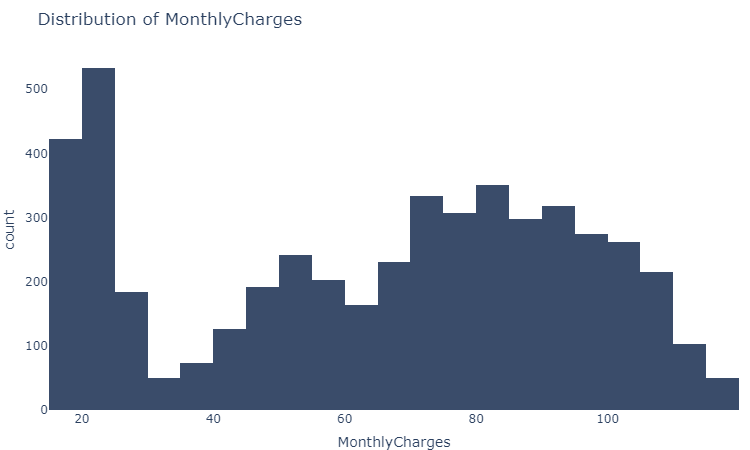

As we can see from the tenure and MonthlyCharges, they have not normal distribution, so we will also do scaling on these columns.

### 5.3. Churn Proportion

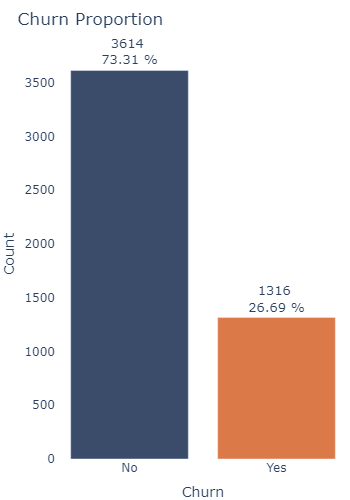

In [16]:
# Calculate churn proportions for bar plot
bar_churn = df['Churn'].value_counts().to_frame().reset_index().set_axis(['is Churn', 'Count'], axis=1)
bar_churn['Percentage'] = [str(round((i / bar_churn['Count'].sum()) * 100, 2)) + ' %' for i in bar_churn['Count']]

# Map 'is Churn' values to meaningful labels
bar_churn['is Churn'] = bar_churn['is Churn'].map({1: 'Yes', 0: 'No'})

# Create bar plot for churn
fig_bar = px.bar(
    bar_churn,
    x='is Churn',
    y='Count',
    title='Churn Proportion',
    color='is Churn',
    color_discrete_map={'Yes': '#dc7949', 'No': '#3A4C6A'},
    text=['{} <br>{}'.format(v, p) for v, p in zip(bar_churn['Count'], bar_churn['Percentage'])],
    labels={'is Churn': 'Churn'}
)

fig_bar.update_layout(
    autosize=False,
    width=350,
    height=500,
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

fig_bar.update_traces(textfont_size=13, textangle=0, cliponaxis=False, textposition="outside")

# Show the plot
fig_bar.show()

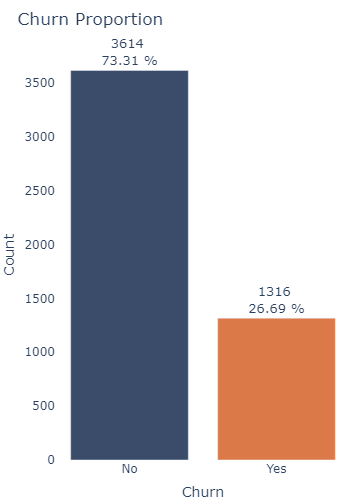

The churn proportion plot reveals that 73.31% of customers (3614 individuals) have not churned, indicating a high retention rate, while 26.69% (1316 individuals) have churned, highlighting a significant area for improvement. This substantial churn rate suggests a need for targeted retention strategies, personalized offers, and proactive customer engagement to enhance satisfaction and loyalty.

### 5.4. Tenure vs Monthly Charges based on Churn

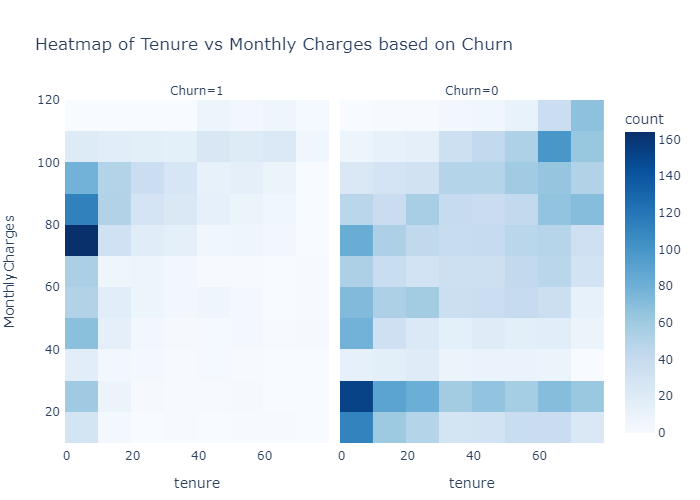

In [17]:
# Create heatmap for tenure vs MonthlyCharges
fig_heatmap_churn = px.density_heatmap(df, x='tenure', y='MonthlyCharges', facet_col='Churn', title='Heatmap of Tenure vs Monthly Charges based on Churn', color_continuous_scale='Blues')

fig_heatmap_churn.update_layout(
    autosize=False,
    width=700,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=100,
        pad=4
    ),
    plot_bgcolor='white',
    showlegend=True
)

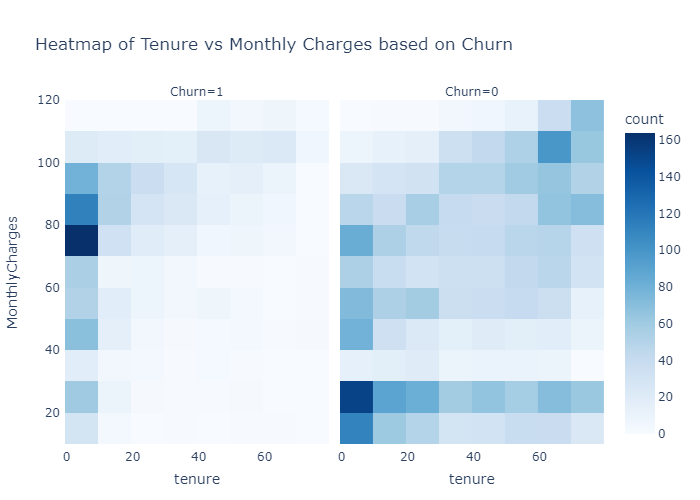

The heatmap of tenure versus monthly charges based on churn shows distinct patterns. Customers with a shorter tenure (0-9 Months) and higher monthly charges are more likely to churn, as evidenced by the denser concentration in the upper left of the churn=1 plot. Conversely, customers with longer tenures and moderate monthly charges are less likely to churn, indicated by the spread across the tenure axis in the churn=0 plot. This suggests that newer customers facing higher costs are at greater risk of leaving, highlighting the need for targeted retention strategies for this group. 

### 5.5. Contract based on Churn

In [18]:
def chi_visualize(series_x, series_y=df['Churn'],width=300,height=450):
    con_table = pd.crosstab(series_x, series_y, margins=False, normalize='index')
    x = [
        [con_table.index.name]* con_table.shape[0],
        con_table.index.to_list()[::-1]
    ]
    y1 = con_table[1].to_list()[::-1]
    y2 = con_table[0].to_list()[::-1]

    fig = go.Figure()
    fig.add_bar(
        x=x,
        y=y1,
        marker_color='#DC7949',
        text= [f'{np.round(i*100,2)}%' for i in y1],
        name='Churn'
        )
    fig.add_bar(
        x=x,
        y=y2,
        marker_color = '#3A4C6A',
        text= [f'{np.round(i*100,2)}%' for i in y2],
        name='No Churn'
        )
    fig.update_layout(
        barmode="relative",
        autosize=True,
        width=width,
        height=height,
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0,
            pad=0
            ),
        plot_bgcolor='white',
        showlegend=False,
        yaxis= dict(visible=False),
        font=dict(size=17)
            )
    fig.update_traces(textfont_size=17, textangle=0, cliponaxis=False, textposition="inside", textfont_color='white')
    fig.show()

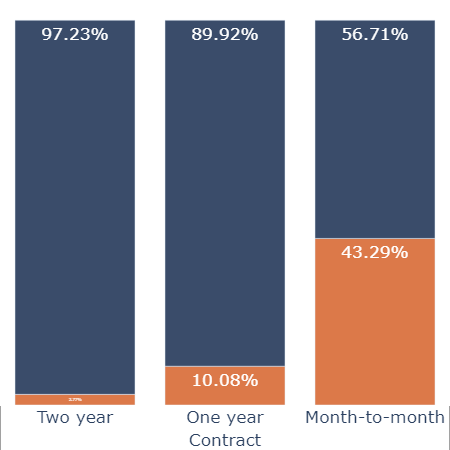

In [19]:
chi_visualize(df['Contract'], df['Churn'], 450)

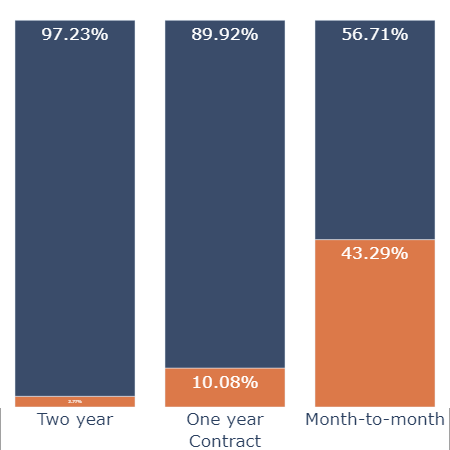

The bar chart shows churn rates by contract type: two-year contracts have the lowest churn at 2.77%, one-year contracts have a moderate churn at 10.08%, and month-to-month contracts have the highest churn at 43.29%. This indicates that longer-term contracts are more effective at retaining customers, while month-to-month customers are at higher risk of churn, highlighting the need for targeted retention strategies for this group.

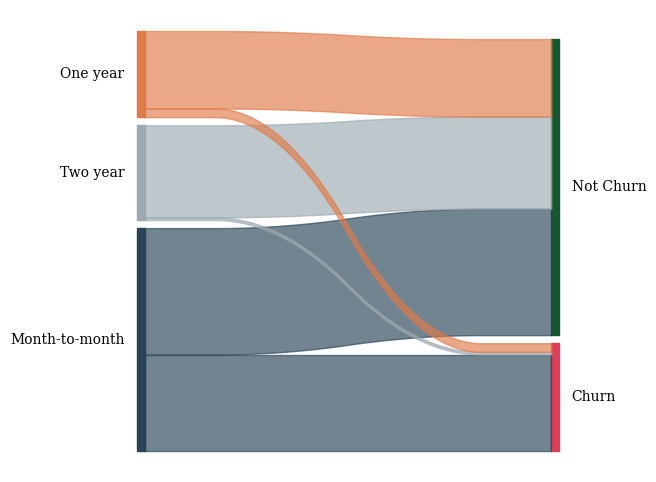

In [20]:
colorDict = {
    'Two year':'#9ca9b0',
    'One year':'#df7a48',
    'Month-to-month':'#284256',
    'Churn':'#df3b57',
    'Not Churn':'#12562a'
}
sankey(df['Contract'], df['Churn'].replace({1:'Churn',0:'Not Churn'}) ,colorDict=colorDict,fontsize=10, aspect=100)

### 5.6. Internet Service based on Churn

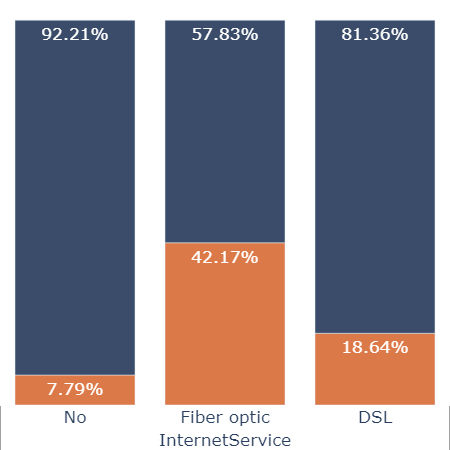

In [21]:
chi_visualize(df['InternetService'], df['Churn'], 450)

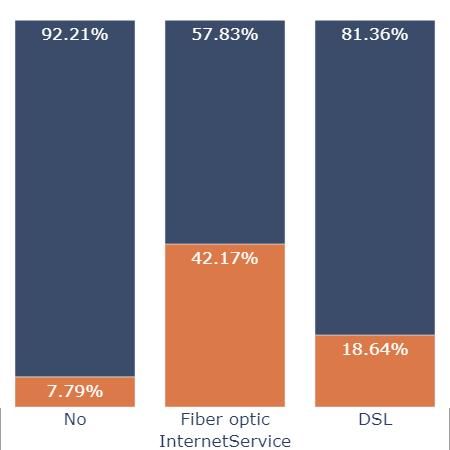

The bar chart shows churn rates by internet service type: customers without internet service have the lowest churn at 7.79%, DSL users have a moderate churn rate of 18.64%, and fiber optic users have the highest churn at 42.17%. This suggests fiber optic customers are at the highest risk of churn, indicating a need for targeted retention efforts in this group.

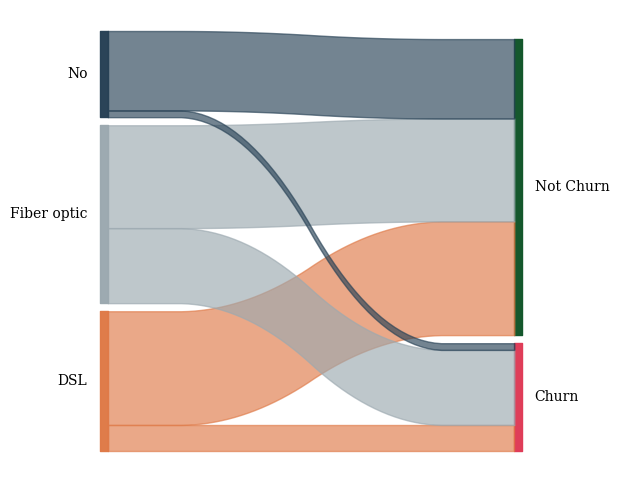

In [22]:
colorDict = {
    'Fiber optic':'#9ca9b0',
    'DSL':'#df7a48',
    'No':'#284256',
    'Churn':'#df3b57',
    'Not Churn':'#12562a'
}
sankey(df['InternetService'], df['Churn'].replace({1:'Churn',0:'Not Churn'}) ,colorDict=colorDict,fontsize=10, aspect=100)

# 6. Data Transformation

In [23]:
# Define encoding column

onehot_var = ['Dependents', 'PaperlessBilling']
binary_var = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'InternetService', 'Contract']
numerical_var = ['tenure', 'MonthlyCharges', 'TotalCharged']

In [24]:
# Column transform

transformer = ColumnTransformer([
    ('binary encoder', BinaryEncoder(), binary_var),
    ('onehot encoder', OneHotEncoder(drop='first'), onehot_var),
    ('num', StandardScaler(), numerical_var)
],remainder="passthrough")

In [25]:
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('binary encoder', BinaryEncoder(),
                                 ['OnlineSecurity', 'OnlineBackup',
                                  'DeviceProtection', 'TechSupport',
                                  'InternetService', 'Contract']),
                                ('onehot encoder', OneHotEncoder(drop='first'),
                                 ['Dependents', 'PaperlessBilling']),
                                ('num', StandardScaler(),
                                 ['tenure', 'MonthlyCharges', 'TotalCharged'])])

# 7. Modeling

In [26]:
# Feature Selection

X = df.drop(['Churn'], axis=1)
y = df['Churn']


In [27]:
# Data Splitting

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    stratify=y,
    random_state=42)

### 7.1. Model Benchmarking

In [28]:
# Base Models

dtc = DecisionTreeClassifier(max_depth=7, random_state=42)
knn = KNeighborsClassifier()
lr = LogisticRegression(random_state=42)
svc = SVC(random_state=42)
nb = GaussianNB()

In [29]:
# Ensemble Models - Same Type (Bagging)

# Create a random forest Classifier
rf = RandomForestClassifier(random_state=42)

In [30]:
# Ensemble Models - Same Type (Boosting)

# Create Classifier
ada = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
xgb = XGBClassifier(random_state=42)

In [31]:
# Define custom F2 scorer
f2_scorer = make_scorer(fbeta_score, beta=2)

In [32]:
# Resamplers
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state=42)
rus = RandomUnderSampler(random_state=42)
nm = NearMiss()
iht = InstanceHardnessThreshold(random_state=42)

The scores may not be suitable when the classes are imbalanced or when False Positives and False Negatives have different costs. So we will also do resampling.

In [33]:
# List of models and resamplers
model_list = [dtc, knn, lr, svc, nb, rf, ada, gbc]
resampler_list = [smote, ros, rus, nm, iht]

# Model and resampler names for dataframe
model_names = ['DT', 'KNN', 'LR', 'SVC', 'NB', 'RF', 'ADA', 'GBC']
resampler_names = ['SMOTE', 'ROS', 'RUS', 'NM', 'IHT']

In [34]:
# Check the best benchmark model

# Lists to store scores
model_score = []
train_score = []
std_value = []

# Loop through models and resamplers
for model in model_list:
    for resampler in resampler_list:
        model_pipeline = Pipeline([
            ('prep', transformer), 
            ('resample', resampler),
            ('model', model)
        ])
        
        # Import K-fold
        skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Cross-validation scoring
        cv_scores = cross_val_score(model_pipeline, 
                                    X_train, 
                                    y_train, 
                                    cv=skfold, 
                                    scoring=f2_scorer)
        
        # Store the results
        model_score.append(cv_scores)
        train_score.append(cv_scores.mean())
        std_value.append(cv_scores.std())

# Create dataframe to store the results
benchmark_model_train = pd.DataFrame({
    'Model': [f"{model_name}-{resampler_name}" for model_name in model_names for resampler_name in resampler_names],
    'F2 Score on Train': train_score,
    'Std': std_value
}).sort_values(by='F2 Score on Train', ascending=False)

# Display the resulting dataframe
benchmark_model_train

,Model,F2 Score on Train,Std
34,ADA-IHT,0.740637,0.019336
9,KNN-IHT,0.737555,0.014540
39,GBC-IHT,0.737400,0.021064
14,LR-IHT,0.734841,0.014526
4,DT-IHT,0.733242,0.018554
29,RF-IHT,0.731868,0.016461
19,SVC-IHT,0.726730,0.020780
32,ADA-RUS,0.726247,0.017570
24,NB-IHT,0.725493,0.022525
22,NB-RUS,0.719991,0.022431


In [35]:
# Check the best benchmark model on test

test_score = []

# Loop through models and resamplers
for model, model_name in zip(model_list, model_names):
    for resampler, resampler_name in zip(resampler_list, resampler_names):
        model_pipeline = Pipeline([
            ('prep', transformer), 
            ('resample', resampler),
            ('model', model)
        ])

        # Fitting
        model_pipeline.fit(X_train, y_train)

        # Predict
        y_pred_test = model_pipeline.predict(X_test)

        # Evaluate
        f2 = fbeta_score(y_test, y_pred_test, beta=2)  # Directly using fbeta_score for F2 score
        test_score.append(f2)

# Create dataframe to store the results
benchmark_model_test = pd.DataFrame({
    'Model': [f"{model_name}-{resampler_name}" for model_name in model_names for resampler_name in resampler_names],
    'F2 Score on Test': test_score
}).sort_values(by='F2 Score on Test', ascending=False)

# Display the resulting dataframe
benchmark_model_test


,Model,F2 Score on Test
29,RF-IHT,0.762454
19,SVC-IHT,0.762454
14,LR-IHT,0.761468
39,GBC-IHT,0.759417
34,ADA-IHT,0.756379
9,KNN-IHT,0.754139
21,NB-ROS,0.750789
22,NB-RUS,0.749686
20,NB-SMOTE,0.748899
4,DT-IHT,0.747863


In [36]:
# Combine and compare

benchmark_model = benchmark_model_train.set_index('Model').join(benchmark_model_test.set_index('Model'))
benchmark_model.drop(columns = 'Std', inplace=True)
benchmark_model['Diff'] = benchmark_model['F2 Score on Test'] - benchmark_model['F2 Score on Train']
benchmark_model['Diff'] = benchmark_model['Diff'].agg(abs)
benchmark_model.sort_values(by='F2 Score on Test', ascending=False)

C:\Users\rifqi\AppData\Local\Temp\ipykernel_17364\2553901643.py:6: FutureWarning:

using <built-in function abs> in Series.agg cannot aggregate and has been deprecated. Use Series.transform to keep behavior unchanged.



,F2 Score on Train,F2 Score on Test,Diff
Model,,,
RF-IHT,0.731868,0.762454,0.030587
SVC-IHT,0.726730,0.762454,0.035724
LR-IHT,0.734841,0.761468,0.026627
GBC-IHT,0.737400,0.759417,0.022017
ADA-IHT,0.740637,0.756379,0.015743
KNN-IHT,0.737555,0.754139,0.016583
NB-ROS,0.718017,0.750789,0.032772
NB-RUS,0.719991,0.749686,0.029695
NB-SMOTE,0.719554,0.748899,0.029345


**Best Model on F2 Score** : RF-IHT<br>
**Best Model on Stability** : ADA-ROS

### 7.2. Random Forest (IHT)

Model Performance in Test

In [37]:
model_rf = Pipeline([
            ('prep', transformer), 
            ('resample', iht),
            ('model', rf)
        ])

# Fitting
model_rf.fit(X_train, y_train)

# Predict
y_pred = model_rf.predict(X_test)

print(f'F2 Score: {fbeta_score(y_test, y_pred, beta=2):.4f}')

F2 Score: 0.7625


In [38]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.53      0.68       723
           1       0.42      0.95      0.59       263

    accuracy                           0.64       986
   macro avg       0.70      0.74      0.63       986
weighted avg       0.82      0.64      0.66       986



##### 7.2.1. Hyperparameter Tuning

In [39]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [10, 20, 30],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['auto', 'sqrt', 'log2'],
    'model__class_weight': [None, 'balanced', 'balanced_subsample']
}

# Create Algorithm Chain
model_rf = Pipeline([
    ('prep', transformer), 
    ('resample', iht),
    ('model', rf)
])

# Import K-fold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Hyperparameter Tuning
grid_search_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring=f2_scorer,
    cv=skfold,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search_rf.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


c:\Users\rifqi\anaconda3\Lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning:

`max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.



GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('binary '
                                                                         'encoder',
                                                                         BinaryEncoder(),
                                                                         ['OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'InternetService',
                                                                          'Contract']),
                                                                        ('onehot '
                                                                         'encoder',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['Depend...
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__class_weight': [None, 'balanced',
                                                 'balanced_subsample'],
                         'model__max_depth': [10, 20, 30],
                         'model__max_features': ['auto', 'sqrt', 'log2'],
                         'model__min_samples_leaf': [1, 2, 4],
                         'model__min_samples_split': [2, 5, 10],
                         'model__n_estimators': [100, 200, 300]},
             scoring=make_scorer(fbeta_score, beta=2), verbose=2)

In [40]:
print(f'Best Parameters: {grid_search_rf.best_params_}')
print(f'Best F2 Score on Train: {grid_search_rf.best_score_}')

Best Parameters: {'model__class_weight': None, 'model__max_depth': 20, 'model__max_features': 'auto', 'model__min_samples_leaf': 4, 'model__min_samples_split': 10, 'model__n_estimators': 300}
Best F2 Score on Train: 0.7424557965141622


Model Performance in Test

In [41]:
rf = RandomForestClassifier(random_state=42,
                            class_weight = None, 
                            max_depth = 20, 
                            max_features = 'sqrt', 
                            min_samples_leaf = 4, 
                            min_samples_split = 10, 
                            n_estimators = 300)

model_rf_tuned = Pipeline([
            ('prep', transformer), 
            ('resample', iht),
            ('model', rf)])

# Fitting
model_rf_tuned.fit(X_train, y_train)

# Predict
y_pred_tuned = model_rf_tuned.predict(X_test)

print(f'F2 Score: {fbeta_score(y_test, y_pred_tuned, beta=2):.4f}')

F2 Score: 0.7648


In [42]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.97      0.53      0.69       723
           1       0.43      0.95      0.59       263

    accuracy                           0.65       986
   macro avg       0.70      0.74      0.64       986
weighted avg       0.82      0.65      0.66       986



##### 7.2.2. Model Evaluation (Before - After Tuning)

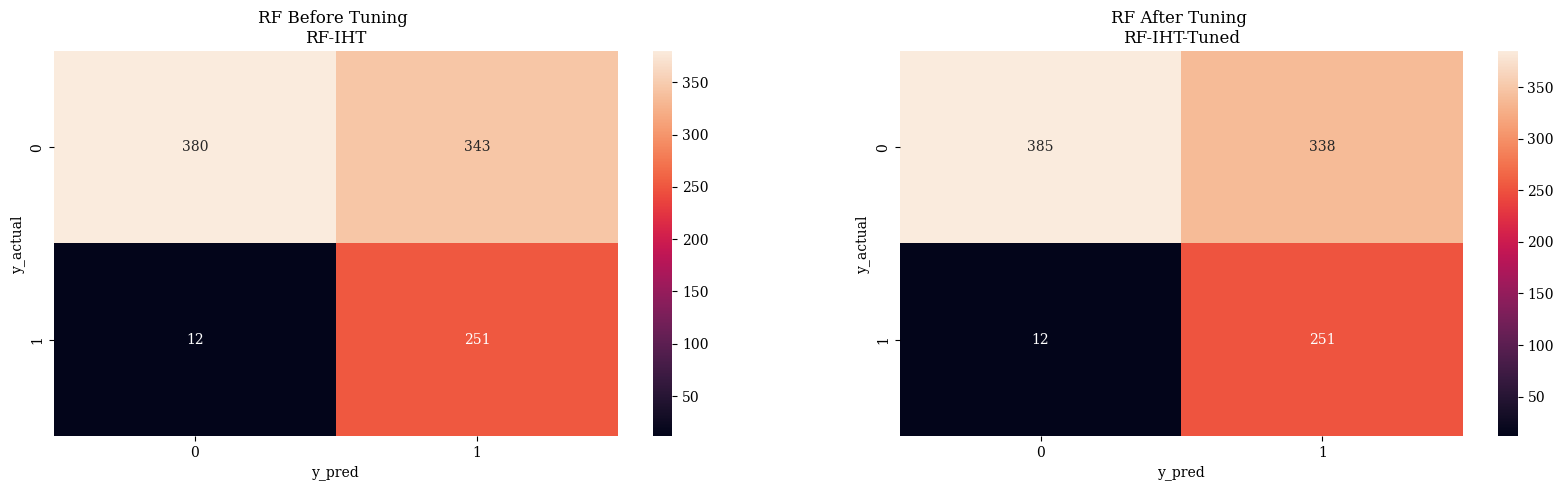

In [43]:
plt.figure(figsize=(20,5))

# Before Hyperparameter Tuning
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f')
plt.xlabel('y_pred')  
plt.ylabel('y_actual')
plt.title('RF Before Tuning \nRF-IHT')

# After Hyperparameter Tuning
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='.0f')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('RF After Tuning \nRF-IHT-Tuned')

plt.show()

**Best Model** : Random Forest with IHT resampling and tuned. We will continue to feature selection.<br>

##### 7.2.3. Feature Importances

In [44]:
features = list(transformer.get_feature_names_out())

list_features = []

for feature in features:
    list_features.append('_'.join(feature.split('_')[2:]))

list_features

['OnlineSecurity_0',
 'OnlineSecurity_1',
 'OnlineBackup_0',
 'OnlineBackup_1',
 'DeviceProtection_0',
 'DeviceProtection_1',
 'TechSupport_0',
 'TechSupport_1',
 'InternetService_0',
 'InternetService_1',
 'Contract_0',
 'Contract_1',
 'Dependents_Yes',
 'PaperlessBilling_Yes',
 'tenure',
 'MonthlyCharges',
 'TotalCharged']

In [45]:
# Assign feature importance to variable
imp = model_rf_tuned[-1].feature_importances_
imp

array([0.01657462, 0.01874026, 0.02109241, 0.021906  , 0.035934  ,
       0.01993555, 0.09872326, 0.01791984, 0.08839066, 0.02305233,
       0.29384207, 0.11003409, 0.00405146, 0.00800171, 0.10995763,
       0.05057264, 0.06127146])

In [46]:
# To Dataframe
feature_imp = pd.DataFrame({
    'Importance':imp,
    'Feature':list_features
}).sort_values(by='Importance',ascending=False)

feature_imp

,Importance,Feature
10,0.293842,Contract_0
11,0.110034,Contract_1
14,0.109958,tenure
6,0.098723,TechSupport_0
8,0.088391,InternetService_0
16,0.061271,TotalCharged
15,0.050573,MonthlyCharges
4,0.035934,DeviceProtection_0
9,0.023052,InternetService_1
3,0.021906,OnlineBackup_1


##### 7.2.4. Feature Selection

In [47]:
rf = RandomForestClassifier(random_state=42,
                            class_weight = None, 
                            max_depth = 20, 
                            max_features = 'sqrt', 
                            min_samples_leaf = 4, 
                            min_samples_split = 10, 
                            n_estimators = 300)

model_rf_selected = Pipeline([
            ('prep', transformer), 
            ('resample', iht),
            ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42), max_features=5)),
            ('model', rf)])

# Fitting
model_rf_selected.fit(X_train, y_train)

# Predict
y_pred_selected = model_rf_selected.predict(X_test)

print(f'F2 Score: {fbeta_score(y_test, y_pred_selected, beta=2):.4f}')

F2 Score: 0.7664


In [48]:
print(classification_report(y_test, y_pred_selected))

              precision    recall  f1-score   support

           0       0.97      0.54      0.70       723
           1       0.43      0.95      0.59       263

    accuracy                           0.65       986
   macro avg       0.70      0.75      0.65       986
weighted avg       0.83      0.65      0.67       986



##### 7.2.5. Model Evaluation (Before - After Feature Selection)

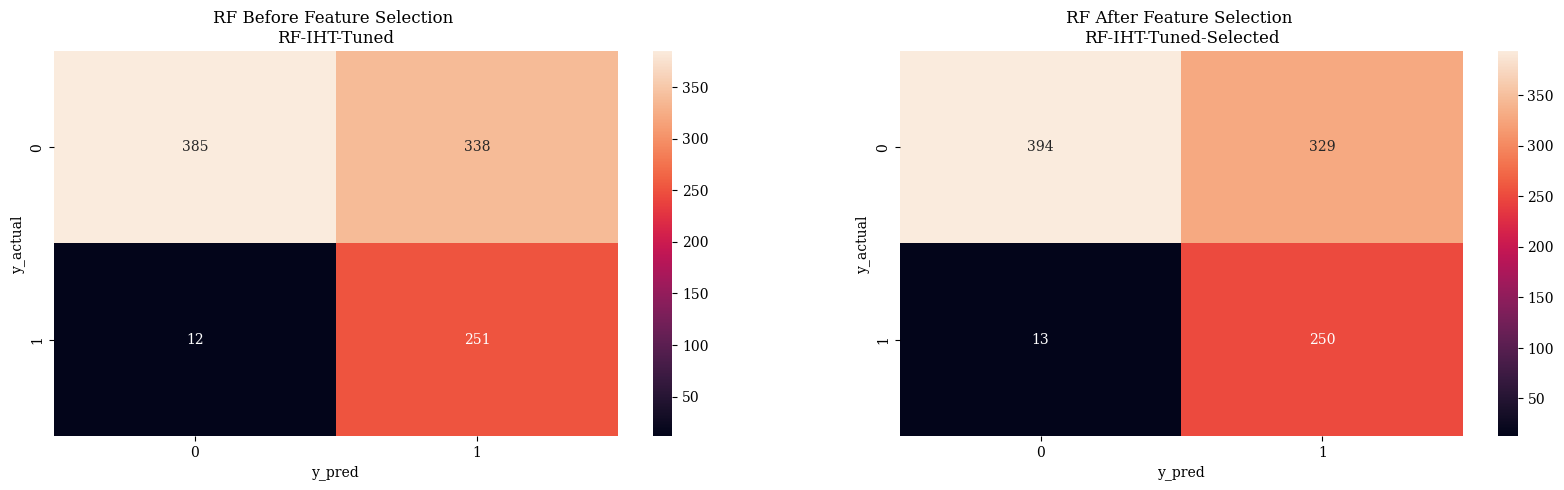

In [49]:
plt.figure(figsize=(20,5))

# Before Feature Selection
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='.0f')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('RF Before Feature Selection \nRF-IHT-Tuned')

# After Feature Selection
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_selected), annot=True, fmt='.0f')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('RF After Feature Selection \nRF-IHT-Tuned-Selected')

plt.show()

**Best Model** remains : Random Forest with IHT resampling and tuned. Although the F2 Score slightly different, we will pick the model before feature selection, since it minimize the False Negative (FN). We will continue to threshold adjustment.<br>

##### 7.2.6. Threshold Adjustment

In [50]:
# Predict Probabilities

model_rf_threshold = model_rf_tuned

y_hat = model_rf_threshold.predict_proba(X_test)

#------------------------------------------

th_value = [i/100 for i in range(20,80)]
score_list = []
score = 0

for i in th_value:

    # Predict
    y_prob = model_rf_threshold.predict_proba(X_test)[:,1]
    y_pred_th = np.where(y_prob>i,1,0)

    score_temp = fbeta_score(y_test, y_pred_th, beta=2)
    score_list.append(score_temp)

    if score_temp > score:
        score = score_temp

        best_score = score
        best_th = i

print('Best F2 Score :', best_score)
print('Best Threshold :', best_th)

Best F2 Score : 0.7766367137355583
Best Threshold : 0.75


In [51]:
print(classification_report(y_test, y_pred_th))

              precision    recall  f1-score   support

           0       0.94      0.66      0.78       723
           1       0.49      0.89      0.63       263

    accuracy                           0.72       986
   macro avg       0.72      0.78      0.70       986
weighted avg       0.82      0.72      0.74       986



##### 7.2.7. Model Evaluation (Before - After Adjusting Threshold)

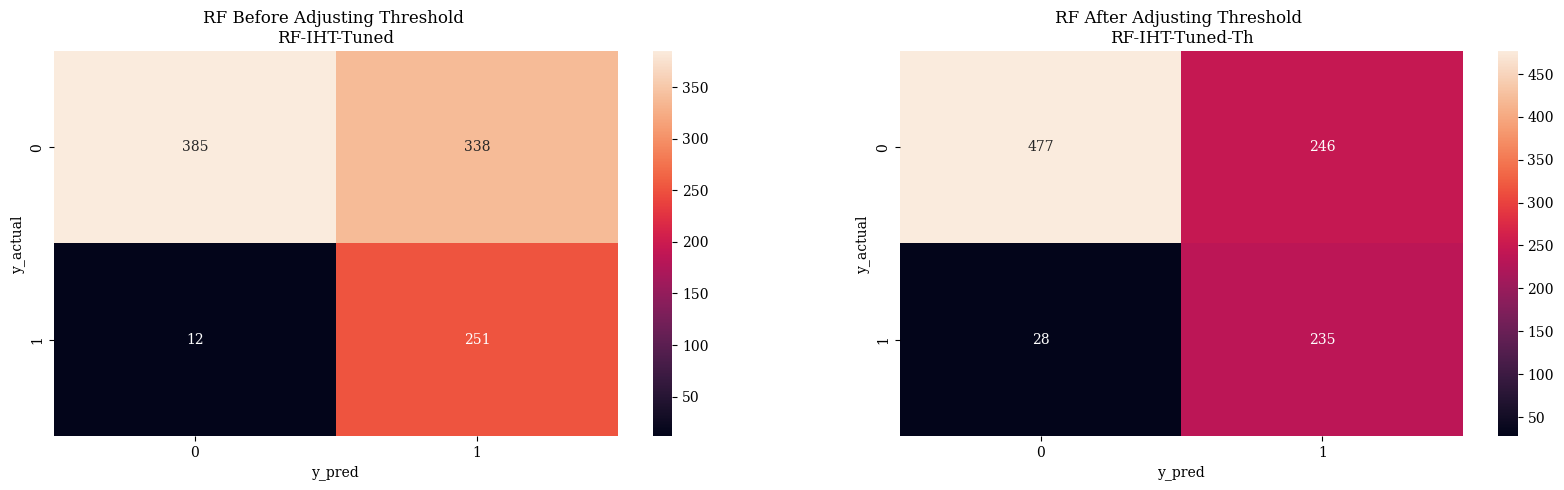

In [52]:
plt.figure(figsize=(20,5))

# Before Adjusting Threshold
plt.subplot(1,2,1)
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='.0f')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('RF Before Adjusting Threshold \nRF-IHT-Tuned')

# After Adjusting Threshold
plt.subplot(1,2,2)
sns.heatmap(confusion_matrix(y_test, y_pred_th), annot=True, fmt='.0f')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('RF After Adjusting Threshold \nRF-IHT-Tuned-Th')

plt.show()

**Best Model** remains : Random Forest with IHT resampling and tuned. Although the adjusted threshold model got the better F2 Score, the False Negative (FN) is more than twice as before. So we pick the model before we do the adjustment.<br>

# 8. Final Model

In [53]:
# Best Model
model_final = model_rf_tuned

In [54]:
model_final

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary encoder',
                                                  BinaryEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'InternetService',
                                                   'Contract']),
                                                 ('onehot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'PaperlessBilling']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharged'])])),
                ('resample', InstanceHardnessThreshold(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=300,
                                        random_state=42))])

# 9. Model Explanation

### 9.1. Feature Importances

In [55]:
features = list(model_final[0].get_feature_names_out())

list_features = []

for feature in features:
    list_features.append('_'.join(feature.split('_')[2:]))

list_features

['OnlineSecurity_0',
 'OnlineSecurity_1',
 'OnlineBackup_0',
 'OnlineBackup_1',
 'DeviceProtection_0',
 'DeviceProtection_1',
 'TechSupport_0',
 'TechSupport_1',
 'InternetService_0',
 'InternetService_1',
 'Contract_0',
 'Contract_1',
 'Dependents_Yes',
 'PaperlessBilling_Yes',
 'tenure',
 'MonthlyCharges',
 'TotalCharged']

In [56]:
# Assign feature importance to variable
imp = model_final[-1].feature_importances_
imp

array([0.01657462, 0.01874026, 0.02109241, 0.021906  , 0.035934  ,
       0.01993555, 0.09872326, 0.01791984, 0.08839066, 0.02305233,
       0.29384207, 0.11003409, 0.00405146, 0.00800171, 0.10995763,
       0.05057264, 0.06127146])

In [57]:
# To Dataframe
feature_imp = pd.DataFrame({
    'Importance':imp,
    'Feature':list_features
}).sort_values(by='Importance',ascending=False)

feature_imp

,Importance,Feature
10,0.293842,Contract_0
11,0.110034,Contract_1
14,0.109958,tenure
6,0.098723,TechSupport_0
8,0.088391,InternetService_0
16,0.061271,TotalCharged
15,0.050573,MonthlyCharges
4,0.035934,DeviceProtection_0
9,0.023052,InternetService_1
3,0.021906,OnlineBackup_1


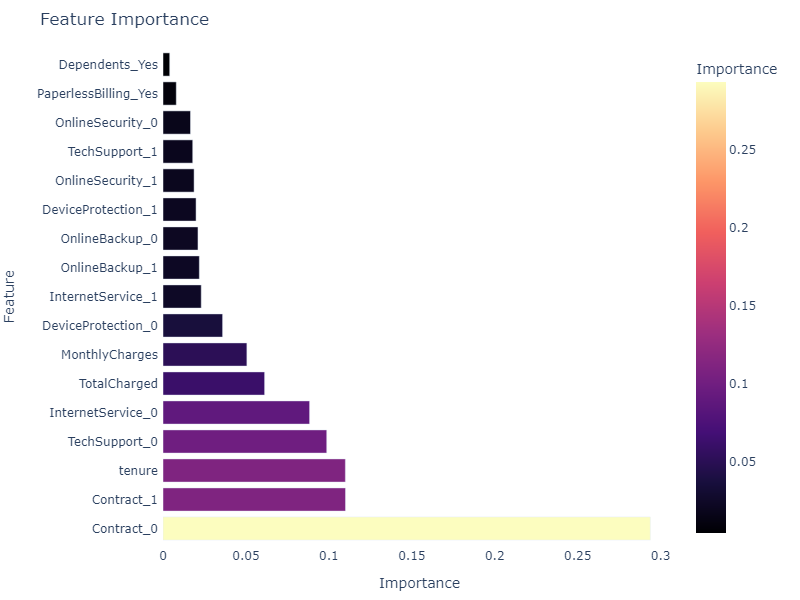

In [58]:
# Visualize the Feature Importances
fig = px.bar(
    feature_imp,
    x='Importance',
    y='Feature',
    title='Feature Importance',
    color='Importance',
    color_continuous_scale='Magma',
    orientation='h'
)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    margin=dict(
        l=50,
        r=50,
        b=50,
        t=50,
        pad=4
    ),
    plot_bgcolor='white',
    showlegend=False
)

fig.show()


The feature importance plot highlights key predictors of customer churn. The most important features are contract type, with 'Contract_0' and 'Contract_1' being the top predictors, followed by tenure and tech support ('TechSupport_0'). Other significant features include monthly charges and total charges. This indicates that contract type and duration, along with the level of support and billing amounts, are critical factors in predicting churn, suggesting areas for focused retention strategies.

### 9.2. SHAP & LIME Explanation

In [59]:
X_train_preprocessed = model_final[0].transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=list_features)

X_test_preprocessed = model_final[0].transform(X_test)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns=list_features)

##### 9.2.1 SHAP

PermutationExplainer explainer: 987it [14:53,  1.10it/s]                         


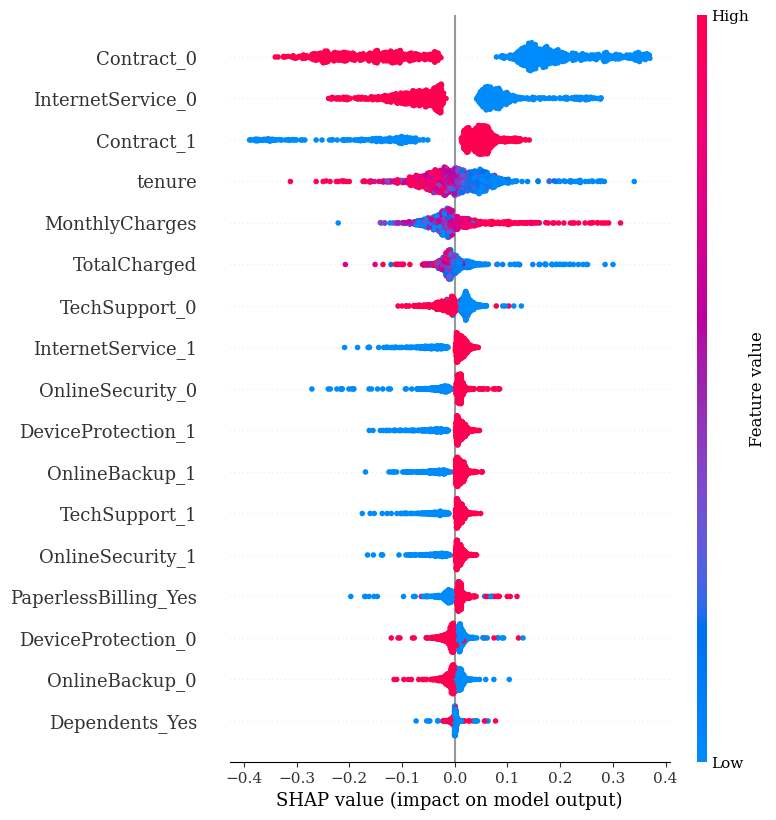

In [60]:
# Explainer

explainer = shap.Explainer(
    model_final[-1].predict,
    model_final[0].transform(X_test),
)

shap_values = explainer(X_test_preprocessed)
shap.summary_plot(shap_values, X_test_preprocessed)

The SHAP value plot indicates the influence of various features on the model's churn predictions. Here are the key insights:

Contract Type:<br>
- Contract_0 (Month-to-month) has a high positive impact on churn, indicating these customers are more likely to churn.
- Contract_1 (Two-year) reduces churn risk, suggesting that customers with longer contracts are more stable.


Internet Service:<br>
- InternetService_0 (Fiber optic) is associated with higher churn risk.
- InternetService_1 (No internet service) reduces churn risk.


Tenure: <br>Longer tenure generally reduces churn risk, indicating that loyal customers are less likely to churn.


Charges: <br>Higher monthly and total charges increase churn risk, suggesting that higher costs may drive customers away.


Support Services:<br>
- TechSupport_0 (No tech support) increases churn risk.
- TechSupport_1 (No internet service) reduces churn risk.


Device Protection:<br>
- DeviceProtection_0 (No device protection) increases churn risk.
- DeviceProtection_1 (No internet service) reduces churn risk.


Online Backup:<br>
- OnlineBackup_0 (No online backup) increases churn risk.
- OnlineBackup_1 (No internet service) reduces churn risk.


Online Security:<br>
- OnlineSecurity_0 (Yes online security) has mixed impacts, but generally lowers churn risk.
- OnlineSecurity_1 (No internet service) reduces churn risk.


These insights highlight that month-to-month contracts, fiber optic internet service, lack of tech support, higher charges, and absence of device protection or online backup services are key factors driving churn. Conversely, two-year contracts, no internet service, and longer tenure are associated with lower churn risk. These factors suggest areas for targeted retention strategies to reduce churn rates.

##### 9.2.2. LIME for each Customer

In [61]:
# Explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data = model_final[0].transform(X_train),
    feature_names = list_features,
    class_names = ['Not Churn','Churn'],
    mode = 'classification'
)

explainer

The prediction of this customer is : No Churn --> from Final Model
The prediction of this customer is : No Churn --> from y_test


c:\Users\rifqi\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\rifqi\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

c:\Users\rifqi\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\rifqi\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.

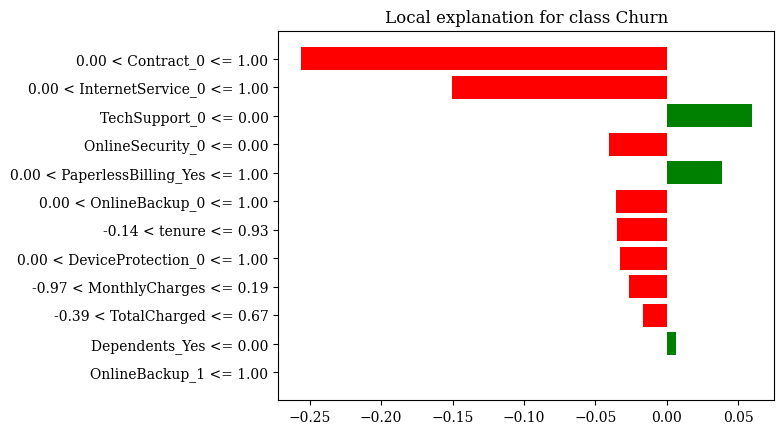

In [62]:
# Lime observation
i = 2

y_pred_tuned = y_pred_tuned.reshape(-1,1)
print(f"The prediction of this customer is : {('Churn' if y_pred_tuned[i] == 1 else 'No Churn')} --> from Final Model")
print(f"The prediction of this customer is : {('Churn' if y_test.iloc[i] == 1 else 'No Churn')} --> from y_test")

exp = explainer.explain_instance(
    X_test_preprocessed.iloc[i],
    model_final['model'].predict_proba,
    num_features = 12
)

exp.as_pyplot_figure()
plt.show()

In [63]:
# Lime observation
i = 2

y_pred_tuned = y_pred_tuned.reshape(-1,1)
print(f"The prediction of this customer is : {('Churn' if y_pred_tuned[i] == 1 else 'No Churn')} --> from Final Model")
print(f"The prediction of this customer is : {('Churn' if y_test.iloc[i] == 1 else 'No Churn')} --> from y_test")

exp = explainer.explain_instance(
    X_test_preprocessed.iloc[i],
    model_final['model'].predict_proba,
)

exp.show_in_notebook(show_table=True)

The prediction of this customer is : No Churn --> from Final Model
The prediction of this customer is : No Churn --> from y_test


c:\Users\rifqi\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\rifqi\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`

c:\Users\rifqi\anaconda3\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

c:\Users\rifqi\anaconda3\Lib\site-packages\lime\discretize.py:110: FutureWarning:

Series.

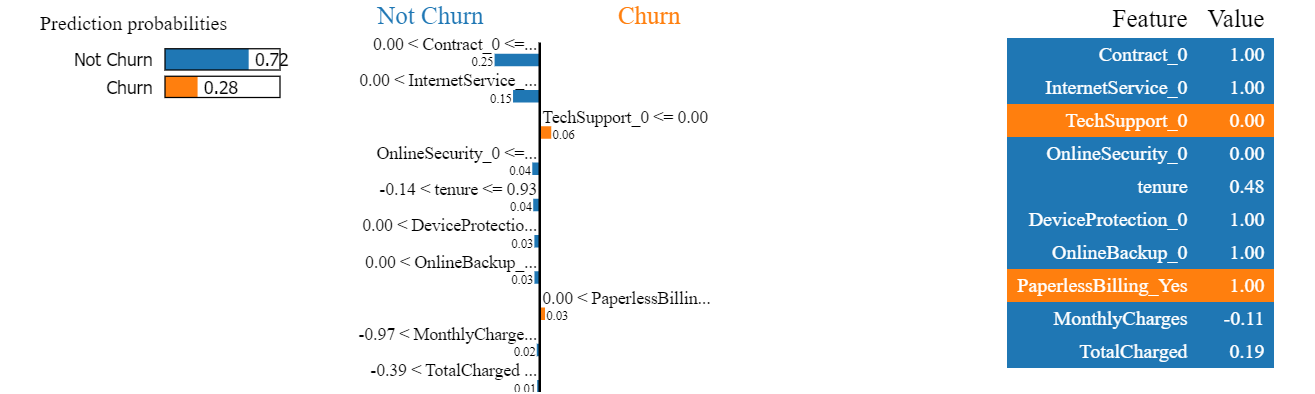

### 9.3. Binary Encoded Features Dictionary

In [64]:
model_final

Pipeline(steps=[('prep',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('binary encoder',
                                                  BinaryEncoder(),
                                                  ['OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport',
                                                   'InternetService',
                                                   'Contract']),
                                                 ('onehot encoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['Dependents',
                                                   'PaperlessBilling']),
                                                 ('num', StandardScaler(),
                                                  ['tenure', 'MonthlyCharges',
                                                   'TotalCharged'])])),
                ('resample', InstanceHardnessThreshold(random_state=42)),
                ('model',
                 RandomForestClassifier(max_depth=20, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=300,
                                        random_state=42))])

In [65]:
X_train_temp = X_train.reset_index(drop=True)

In [66]:
df.columns

Index(['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup',
       'InternetService', 'DeviceProtection', 'TechSupport', 'Contract',
       'PaperlessBilling', 'MonthlyCharges', 'Churn', 'TotalCharged'],
      dtype='object')

1. OnlineSecurity

In [67]:
OnlineSecurity_dict = {}

for i in [0, 1]:
    for j in [0, 1]:
        if (i == 0 and j == 0):
            continue
        idx = X_train_preprocessed[(X_train_preprocessed["OnlineSecurity_0"] == i) & (X_train_preprocessed["OnlineSecurity_1"] == j)].tail(1).index[0]
        value = X_train_temp.loc[idx, "OnlineSecurity"]
        key = [str(k) for k in [i,j]]
        key = "".join(key)
        OnlineSecurity_dict[key] = value

OnlineSecurity_dict

{'01': 'Yes', '10': 'No internet service', '11': 'No'}

2. OnlineBackup

In [68]:
OnlineBackup_dict = {}

for i in [0, 1]:
    for j in [0, 1]:
        if (i == 0 and j == 0):
            continue
        idx = X_train_preprocessed[(X_train_preprocessed["OnlineBackup_0"] == i) & (X_train_preprocessed["OnlineBackup_1"] == j)].tail(1).index[0]
        value = X_train_temp.loc[idx, "OnlineBackup"]
        key = [str(k) for k in [i,j]]
        key = "".join(key)
        OnlineBackup_dict[key] = value

OnlineBackup_dict

{'01': 'No', '10': 'No internet service', '11': 'Yes'}

3. DeviceProtection

In [69]:
DeviceProtection_dict = {}

for i in [0, 1]:
    for j in [0, 1]:
        if (i == 0 and j == 0):
            continue
        idx = X_train_preprocessed[(X_train_preprocessed["DeviceProtection_0"] == i) & (X_train_preprocessed["DeviceProtection_1"] == j)].tail(1).index[0]
        value = X_train_temp.loc[idx, "DeviceProtection"]
        key = [str(k) for k in [i,j]]
        key = "".join(key)
        DeviceProtection_dict[key] = value

DeviceProtection_dict

{'01': 'No', '10': 'No internet service', '11': 'Yes'}

4. TechSupport

In [70]:
TechSupport_dict = {}

for i in [0, 1]:
    for j in [0, 1]:
        if (i == 0 and j == 0):
            continue
        idx = X_train_preprocessed[(X_train_preprocessed["TechSupport_0"] == i) & (X_train_preprocessed["TechSupport_1"] == j)].tail(1).index[0]
        value = X_train_temp.loc[idx, "TechSupport"]
        key = [str(k) for k in [i,j]]
        key = "".join(key)
        TechSupport_dict[key] = value

TechSupport_dict

{'01': 'No', '10': 'No internet service', '11': 'Yes'}

5. InternetService

In [71]:
InternetService_dict = {}

for i in [0, 1]:
    for j in [0, 1]:
        if (i == 0 and j == 0):
            continue
        idx = X_train_preprocessed[(X_train_preprocessed["InternetService_0"] == i) & (X_train_preprocessed["InternetService_1"] == j)].tail(1).index[0]
        value = X_train_temp.loc[idx, "InternetService"]
        key = [str(k) for k in [i,j]]
        key = "".join(key)
        InternetService_dict[key] = value

InternetService_dict

{'01': 'Fiber optic', '10': 'No', '11': 'DSL'}

6. Contract

In [72]:
Contract_dict = {}

for i in [0, 1]:
    for j in [0, 1]:
        if (i == 0 and j == 0):
            continue
        idx = X_train_preprocessed[(X_train_preprocessed["Contract_0"] == i) & (X_train_preprocessed["Contract_1"] == j)].tail(1).index[0]
        value = X_train_temp.loc[idx, "Contract"]
        key = [str(k) for k in [i,j]]
        key = "".join(key)
        Contract_dict[key] = value

Contract_dict

{'01': 'Month-to-month', '10': 'Two year', '11': 'One year'}

Based on the checking above and validate to the feature importance, we can conclude that each column that have been binary encoded can be explain in feature importance with a dictionary below:

Contract_0 = Month-to-month <br>
Contract_1 = Two year<br>
InternetService_0 = Fiber optic<br>
InternetService_1 = No<br>
TechSupport_0 = No<br>
TechSupport_1 = No internet service<br>
DeviceProtection_0 = No<br>
DeviceProtection_1 = No internet service<br>
OnlineBackup_0 = No<br>
OnlineBackup_1 = No internet service<br>
OnlineSecurity_0 = Yes<br>
OnlineSecurity_1 = No internet service<br>


# 10. Conclusion

### 10.1. ML Objective Reached

We got the F2 score on **76.48%**, and the false negative (FN) on **12**. It allows us to predict which customer are likely to churn, with low Type II Error, means the model is pretty confident to not mispredict churn customer as no churn. 

In [73]:
print(f'F2 Score: {fbeta_score(y_test, y_pred_tuned, beta=2):.4f}')

F2 Score: 0.7648


In [74]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.97      0.53      0.69       723
           1       0.43      0.95      0.59       263

    accuracy                           0.65       986
   macro avg       0.70      0.74      0.64       986
weighted avg       0.82      0.65      0.66       986



Text(0.5, 1.0, 'RF Before Adjusting Threshold \nRF-IHT-Tuned')

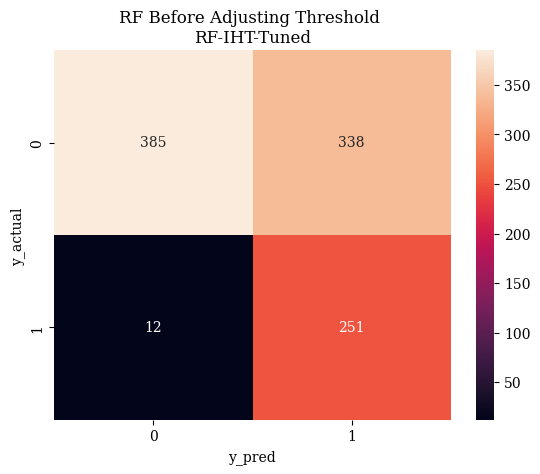

In [75]:
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt='.0f')
plt.xlabel('y_pred')
plt.ylabel('y_actual')
plt.title('RF Before Adjusting Threshold \nRF-IHT-Tuned')

### 10.2. Business Impact

By implementing the machine learning model for churn prediction, the business can achieve significant savings across multiple key metrics. Here’s a detailed breakdown of the impact:

1. Revenue Protection. <br><br>By significantly reducing the potential revenue loss, the business can protect a substantial amount of revenue that would otherwise be lost due to customer churn.<br>
- Before Machine Learning (ML): The potential revenue loss due to all actual churning customers (TP + FN) was calculated to be **$301,606.51**.
- After ML: The potential revenue loss is reduced to **$13,761.51**, as only the False Negatives (FN) represent the customers who churned but were not predicted to churn by the model.
- Savings: The implementation of the machine learning model resulted in a revenue loss reduction of **$287,845**.

2. Cost Efficiency. <br><br>The reduction in retention campaign costs and customer acquisition costs leads to more efficient use of marketing and operational budgets.<br>
- Before ML: The cost of retention campaigns, targeting both True Positives (TP) and False Positives (FP), was **$586**.
- After ML: The cost is reduced to **$251**, targeting only the True Positives (TP).
- Savings: The model reduced the retention campaign costs by **$335**.

3. Customer Acquisition Cost (CAC) reduction.

- Before ML: The cost to acquire new customers to replace all churning customers (TP + FN) was **$82,845**.
- After ML: The cost is reduced to **$3,780**, as the model helps retain many of the at-risk customers, leaving only the False Negatives (FN) to be replaced.
- Savings: The model saved **$79,065** in customer acquisition costs.

4. Customer Retention. <br><br>The model helps in accurately identifying at-risk customers, allowing the stakeholder to focus retention efforts more effectively, thereby increasing customer satisfaction and loyalty. Stakeholder can be informed that **month-to-month contracts**, **fiber optic internet service**, **lack of tech support**, **higher charges**, and **absence of device protection** or **online backup services** are key factors driving churn. These factors suggest areas for targeted retention strategies to reduce churn rates.<br>

<br><br>
**Summary of Savings**:<br>
Potential Revenue Loss Reduction: **$287,845**<br>
Retention Campaign Cost Reduction: **$335**<br>
Customer Acquisition Cost Reduction: **$79,065**<br>
Total Savings: **$367,245**<br>


### 10.3. Business Impact Analysis

Average Monthly Charges: $64.88
Average Tenure for Churning Customers: 17.67 months
Potential Revenue Loss Before ML: $301606.51
Potential Revenue Loss After ML: $13761.51


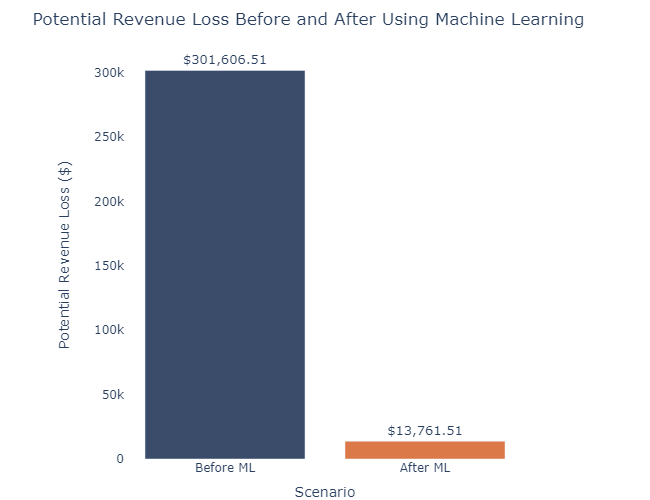

In [76]:
# Potential Revenue Loss Before ML = (TP+FN) x Average Monthly Charges x Average Remaining Lifetime
# Potential Revenue Loss After ML = FN x Average Monthly Charges x Average Remaining Lifetime

# Calculate the average monthly charges
avg_monthly_charges = df['MonthlyCharges'].mean()

# Calculate the average tenure for churning customers
avg_tenure_churn = df[df['Churn'] == 1]['tenure'].mean()

# Display calculated values
print(f"Average Monthly Charges: ${avg_monthly_charges:.2f}")
print(f"Average Tenure for Churning Customers: {avg_tenure_churn:.2f} months")

# Use the average tenure of churning customers as the average remaining lifetime
average_remaining_lifetime = avg_tenure_churn

# Given values
total_churning_customers_before_ml = 263  # FN + TP
false_negatives = 12  # FN

# Calculate potential revenue loss before using machine learning
potential_revenue_loss_before_ml = total_churning_customers_before_ml * avg_monthly_charges * average_remaining_lifetime

# Calculate potential revenue loss after using machine learning
potential_revenue_loss_after_ml = false_negatives * avg_monthly_charges * average_remaining_lifetime

print(f"Potential Revenue Loss Before ML: ${potential_revenue_loss_before_ml:.2f}")
print(f"Potential Revenue Loss After ML: ${potential_revenue_loss_after_ml:.2f}")

# Create a DataFrame for plotting
revenue_plot = {
    'Scenario': ['Before ML', 'After ML'],
    'Potential Revenue Loss': [potential_revenue_loss_before_ml, potential_revenue_loss_after_ml]
}

df_plot = pd.DataFrame(revenue_plot)

# Create bar plot using Plotly Express with the given style
fig_bar = px.bar(
    df_plot,
    x='Scenario',
    y='Potential Revenue Loss',
    title='Potential Revenue Loss Before and After Using Machine Learning',
    color='Scenario',
    color_discrete_map={'Before ML': '#3A4C6A', 'After ML': '#dc7949'},
    text=['${:,.2f}'.format(v) for v in df_plot['Potential Revenue Loss']],
    labels={'Potential Revenue Loss': 'Potential Revenue Loss ($)'}
)

fig_bar.update_layout(
    autosize=False,
    width=650,
    height=500,
    margin=dict(
        l=125,
        r=125,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

fig_bar.update_traces(textfont_size=13, textangle=0, cliponaxis=False, textposition="outside")

# Show the plot
fig_bar.show()

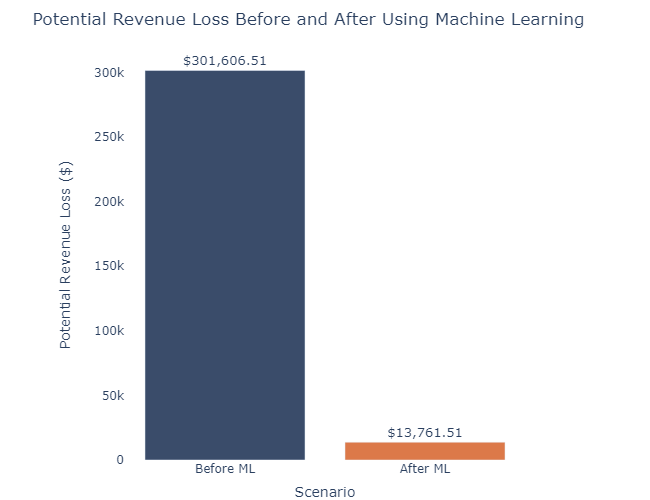

Retention Cost Before ML: $586.00
Retention Cost After ML: $251.00


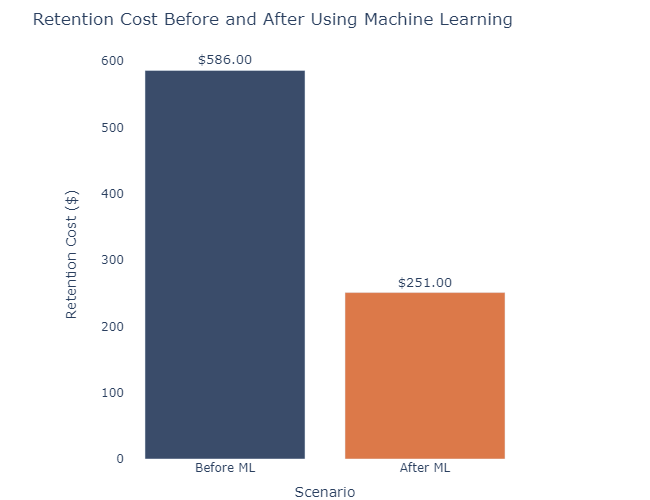

In [77]:
# Retention Cost Before ML = (TP+FP) x Retention Offer Cost per Customer
# Retention Cost After ML = TP x Retention Offer Cost per Customer

# Assumed retention offer cost per customer
retention_offer_cost = 1  # This value can be adjusted based on actual costs

# Given values
true_positives = 251  # TP
false_positives = 335  # FP

# Calculate retention cost before using machine learning
retention_cost_before_ml = (true_positives + false_positives) * retention_offer_cost

# Calculate retention cost after using machine learning
retention_cost_after_ml = true_positives * retention_offer_cost

print(f"Retention Cost Before ML: ${retention_cost_before_ml:.2f}")
print(f"Retention Cost After ML: ${retention_cost_after_ml:.2f}")

# Create a DataFrame for plotting
revenue_plot = {
    'Scenario': ['Before ML', 'After ML'],
    'Retention Cost': [retention_cost_before_ml, retention_cost_after_ml]
}

df_plot = pd.DataFrame(revenue_plot)

# Create bar plot using Plotly Express with the given style
fig_bar = px.bar(
    df_plot,
    x='Scenario',
    y='Retention Cost',
    title='Retention Cost Before and After Using Machine Learning',
    color='Scenario',
    color_discrete_map={'Before ML': '#3A4C6A', 'After ML': '#dc7949'},
    text=['${:,.2f}'.format(v) for v in df_plot['Retention Cost']],
    labels={'Retention Cost': 'Retention Cost ($)'}
)

fig_bar.update_layout(
    autosize=False,
    width=650,
    height=500,
    margin=dict(
        l=125,
        r=125,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

fig_bar.update_traces(textfont_size=13, textangle=0, cliponaxis=False, textposition="outside")

# Show the plot
fig_bar.show()

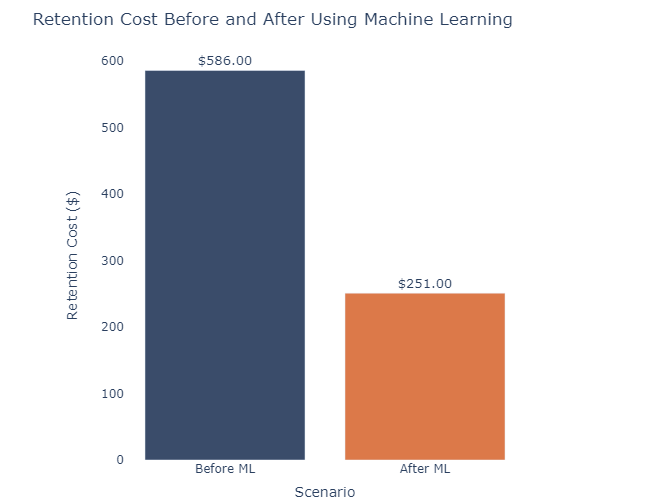

Customer Acquisition Cost Before ML: $82845.00
Customer Acquisition Cost After ML: $3780.00
Customer Acquisition Cost Savings: $79065.00


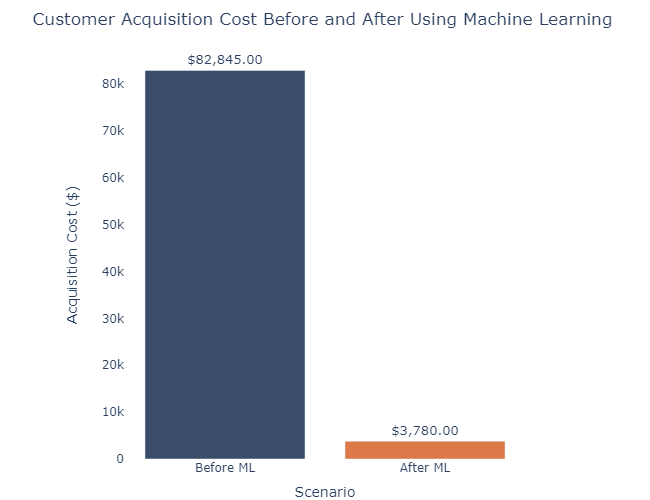

In [78]:
# Acquisition Cost Before ML = (TP+FN) x CAC
# Acquisition Cost After ML = FN x CAC

# Given values
total_churning_customers_before_ml = 263  # FN + TP
true_positives = 251  # TP
false_negatives = 12  # FN
customer_acquisition_cost = 315  # Assumed CAC

# Calculate customer acquisition cost before using machine learning
acquisition_cost_before_ml = total_churning_customers_before_ml * customer_acquisition_cost

# Calculate customer acquisition cost savings
acquisition_cost_after_ml = false_negatives * customer_acquisition_cost
acquisition_cost_savings = acquisition_cost_before_ml - acquisition_cost_after_ml

print(f"Customer Acquisition Cost Before ML: ${acquisition_cost_before_ml:.2f}")
print(f"Customer Acquisition Cost After ML: ${acquisition_cost_after_ml:.2f}")
print(f"Customer Acquisition Cost Savings: ${acquisition_cost_savings:.2f}")

# Create DataFrame for plotting
acquisition_plot = {
    'Scenario': ['Before ML', 'After ML'],
    'Acquisition Cost': [acquisition_cost_before_ml, acquisition_cost_after_ml]
}
df_acquisition_plot = pd.DataFrame(acquisition_plot)

# Create bar plot for acquisition cost using Plotly Express
fig_acquisition_bar = px.bar(
    df_acquisition_plot,
    x='Scenario',
    y='Acquisition Cost',
    title='Customer Acquisition Cost Before and After Using Machine Learning',
    color='Scenario',
    color_discrete_map={'Before ML': '#3A4C6A', 'After ML': '#dc7949'},
    text=['${:,.2f}'.format(v) for v in df_acquisition_plot['Acquisition Cost']],
    labels={'Acquisition Cost': 'Acquisition Cost ($)'}
)

fig_acquisition_bar.update_layout(
    autosize=False,
    width=650,
    height=500,
    margin=dict(
        l=125,
        r=125,
        b=0,
        t=50,
        pad=0
    ),
    plot_bgcolor='white',
    showlegend=False
)

fig_acquisition_bar.update_traces(textfont_size=13, textangle=0, cliponaxis=False, textposition="outside")

# Show the plot for acquisition cost
fig_acquisition_bar.show()


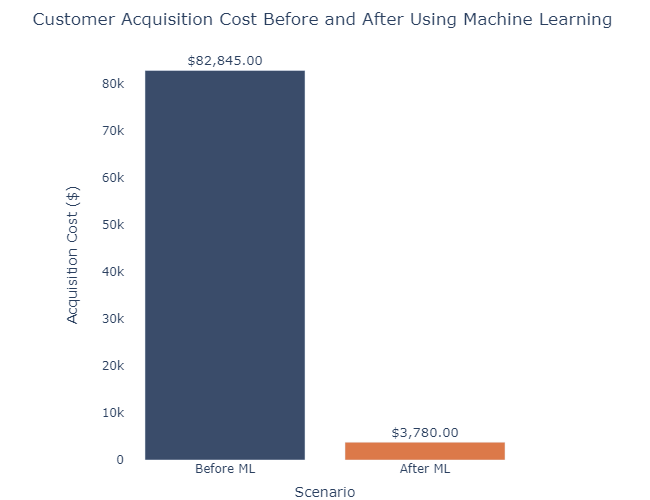

# 11. Recommendation & Limitations

### 11.1. Recommendation

1. Enhance service quality for fiber optic users: Address service quality issues like frequent disconnections or slow speeds experienced by fiber optic users to reduce churn rates.
2. Offer incentives for long-term contracts: Encourage customers to opt for longer contract durations by offering incentives or discounts, thus it will potentially reducing churn rates associated with month-to-month contracts.
3. Improve the initial customer experience: Focus on enhancing the intial customer experience to mitigate early dissatifaction and reduce churn among customers with short tenure periods.
4. Promote additional services: Increase awareness and utilization of additional services such as online security, tech support, and online backup to enhance perceived value and reduce churn rates among customers who do not currently use these services.
5. Enhance tech support accessibility: Improve the accessibility and quality of tech support, as lack of tech support was a significant factor in customer churn. Offering round-the-clock support and easy access to technical assistance can improve customer satisfaction and retention.
6. Implement targeted retention strategies for at-risk groups: Utilize the insights from the SHAP analysis to identify and target specific customer groups at higher risk of churning. Tailored retention strategies can address the unique needs and concerns of these groups, effectively reducing churn.
7. Monitor and address billing and payment issues: Ensure that billing processes are transparent and efficient. Mismanaged billing or dissatisfaction with billing options can lead to churn, so addressing these issues promptly can improve customer satisfaction and retention.
8. Regularly update and refine the churn prediction model: Continuously monitor the performance of the churn prediction model and update it with new data to ensure it adapts to changing customer behaviors and market conditions. This will maintain its accuracy and effectiveness in predicting churn.

### 11.2. Limitations


We must be cautious when making interpretations outside the range of the observed independent variable interval. This model is only applicable to the data range used in this modeling, which is:

- Tenure between 0 and 72 months
- MonthlyCharges between 18.8 and 118.65
- Contract durations of Month-to-month, One year, and Two Year
- InternetService options of 'DSL', 'Fiber Optic', and 'No'
- Dependent and PaperlessBilling with values 'Yes' or 'No'
- OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport with options 'Yes', 'No', or 'No internet service'.

# 12. Deployment

In [79]:
import pickle

model_final = model_rf_tuned
model_final.fit(X_train, y_train)

pickle.dump(model_final, open('model_final_rf.sav', 'wb'))

In [80]:
X_test.to_csv('data_telco_customer_churn_no-target.csv', index=False)